In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import csv 
import datetime as dt
import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
from LSTM import LSTM_model
import os
from torch.autograd import Variable 
from sklearn.model_selection import cross_validate, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
torch.device('cuda')
torch.manual_seed(12)

In [2]:
#Data Grab
BTC = pd.read_csv("data/CBSE_BTC_clean1.csv")
ETH = pd.read_csv("data/CBSE_ETH_clean1.csv")
#Data Manipulation
BTC_subset = BTC[0:800_000]
ETH_subset = ETH[0:800_000]
BTC_X = BTC_subset.loc[:,"timestamp":"volume"]
ETH_X = ETH_subset.loc[:,"timestamp":"volume"]

In [3]:
def get_direction(df):
    returns = pd.DataFrame(df['close'] / df['close'].shift(1) - 1 - .0010)
    result = np.where(returns > 0, 1, 0)
    return result

def preprocess_split(x, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(x)
    Y = y

    ts_split = TimeSeriesSplit(n_splits = 5)
    split_indices = ts_split.split(X_scaled) #generates train/test indices for scaled df
    for train_ind, test_ind in split_indices:
        #initializes the (x,y) values of the train test split
        x_train, x_test = X_scaled[:len(train_ind)], X_scaled[len(train_ind): (len(train_ind) + len(test_ind))]
        y_train, y_test = Y[:len(train_ind)].ravel(), Y[len(train_ind): (len(train_ind)+len(test_ind))].ravel()

    trainX = np.array(x_train)
    testX = np.array(x_test)
    x_train = trainX.reshape(x_train.shape[0], x_train.shape[1])
    x_test = testX.reshape(x_test.shape[0], x_test.shape[1])

    return x_train, x_test, y_train, y_test


In [4]:
#BTC_Y = get_direction(BTC_X)
#ETH_Y = get_direction(ETH_X)
BTC_Y = BTC_X["close"]
minmax = MinMaxScaler()
BTC_Y = minmax.fit_transform(np.array(BTC_Y).reshape(-1, 1))
X_train_pre, X_test_pre, Y_train_pre, Y_test_pre = preprocess_split(BTC_X, BTC_Y)
#BTC_Y = BTC_X["close"]


In [5]:
#PyTorch Preprocessing
X_train_tensor = Variable(torch.Tensor(X_train_pre))
X_test_tensor = Variable(torch.Tensor(X_test_pre))
Y_train_tensor = Variable(torch.Tensor(Y_train_pre))
Y_test_tensor = Variable(torch.Tensor(Y_test_pre))

#Convert to LSTM shape (xdim, timestampdim, ydim)
X_train = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], 1, X_train_tensor.shape[1]))
X_test = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
Y_train = torch.reshape(Y_train_tensor, (Y_train_tensor.shape[0], 1))
Y_test = torch.reshape(Y_test_tensor, (Y_test_tensor.shape[0], 1))

In [6]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

torch.Size([666667, 1, 6]) torch.Size([133333, 1, 6])
torch.Size([666667, 1]) torch.Size([133333, 1])


In [8]:
#Hyperparameters
#input_size = X_train.shape[2]
#hidden_size = 2 # no. of features in hidden state
#num_layers = 1 #no. of LSTM layers
#num_classes = 1 #no. of output classes

In [9]:
#BTCmodel = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train.shape[1])
#BTCmodel.fit(X_train, Y_train, epochs=500, learn_rate=0.002)

In [10]:
#torch.save(BTCmodel, "BTC_LSTM.pt")

In [11]:
BTCmodel = torch.load("models/BTC_LSTM.pt")

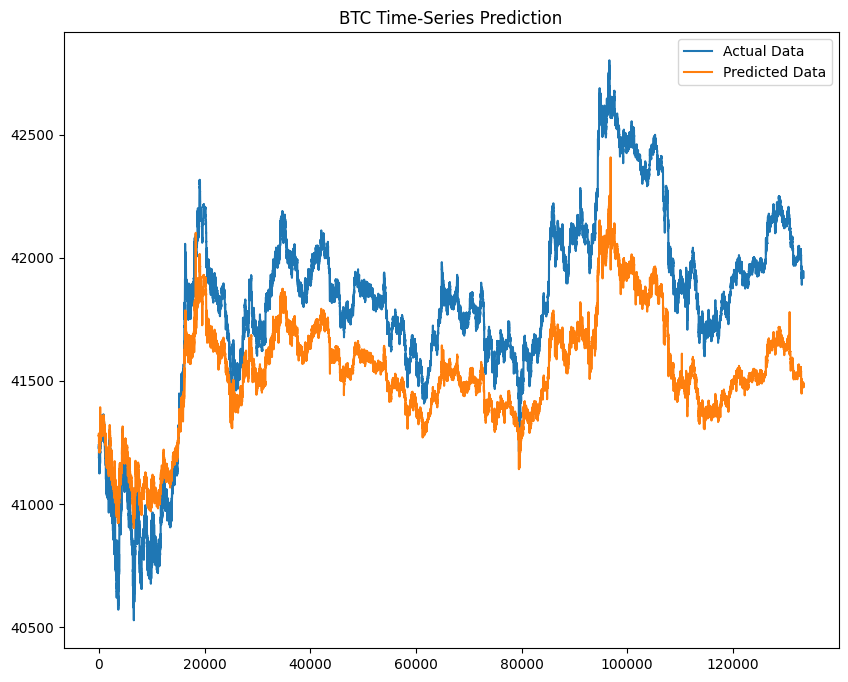

In [12]:
#Prediction
y_pred = minmax.inverse_transform(BTCmodel(X_test).data.numpy())
y_true = minmax.inverse_transform(Y_test)

plt.figure(figsize=(10,8)) #plotting
plt.plot(y_true, label='Actual Data') #actual plot
plt.plot(y_pred, label='Predicted Data') #predicted plot
plt.title('BTC Time-Series Prediction')
plt.legend()
plt.show()

## Ethereum

In [13]:
ETH_Y = ETH_X["close"]
ETH_Y = minmax.fit_transform(np.array(ETH_Y).reshape(-1, 1))
X_train_pre, X_test_pre, Y_train_pre, Y_test_pre = preprocess_split(ETH_X, ETH_Y)

In [14]:
#PyTorch Preprocessing
X_train_tensor = Variable(torch.Tensor(X_train_pre))
X_test_tensor = Variable(torch.Tensor(X_test_pre))
Y_train_tensor = Variable(torch.Tensor(Y_train_pre))
Y_test_tensor = Variable(torch.Tensor(Y_test_pre))

#Convert to LSTM shape (xdim, timestampdim, ydim)
X_train = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], 1, X_train_tensor.shape[1]))
X_test = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
Y_train = torch.reshape(Y_train_tensor, (Y_train_tensor.shape[0], 1))
Y_test = torch.reshape(Y_test_tensor, (Y_test_tensor.shape[0], 1))

In [15]:
#Hyperparameters
#input_size = X_train.shape[2]
#hidden_size = 2 # no. of features in hidden state
#num_layers = 1 #no. of LSTM layers
#num_classes = 1 #no. of output classes

In [16]:
#ETHmodel = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train.shape[1])
#ETHmodel.fit(X_train, Y_train, epochs=500, learn_rate=0.01)

In [17]:
#torch.save(ETHmodel, "ETH_LSTM.pt")

In [18]:
ETHmodel = torch.load("models/ETH_LSTM.pt")

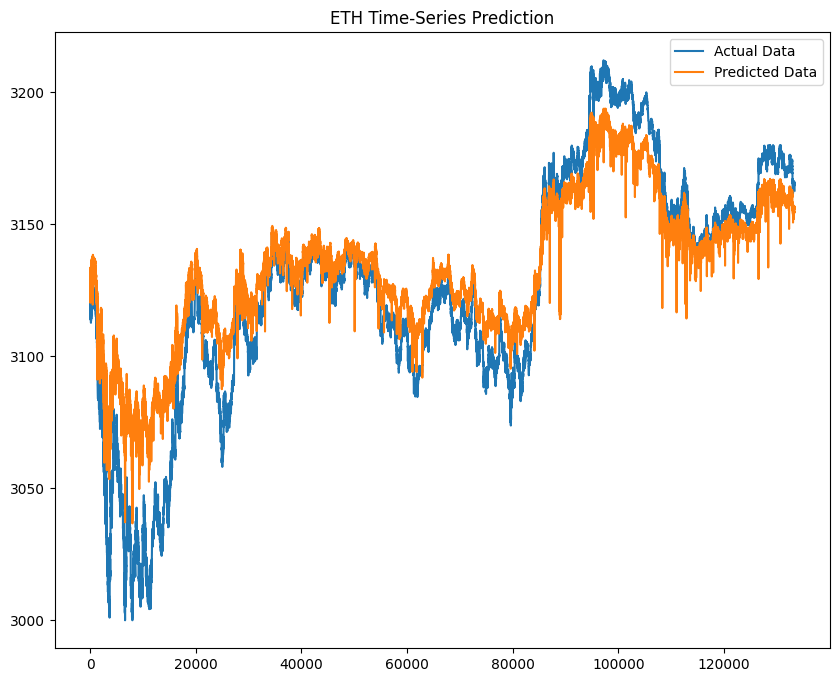

In [19]:
#Prediction
y_pred = minmax.inverse_transform(ETHmodel(X_test).data.numpy())
y_true = minmax.inverse_transform(Y_test)

plt.figure(figsize=(10,8)) #plotting
plt.plot(y_true, label='Actual Data')
plt.plot(y_pred, label='Predicted Data') 
plt.title('ETH Time-Series Prediction')
plt.legend()
plt.show()